In [1]:
import sys
import os

# TODO: this is a hack, change this for editable install
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.functions import *

from src.loss import cross_entropy_loss

In [2]:
def generate_dededup(model_name: str, n_samples: int, max_len: int = 10) -> int:
    X, _ = generateAndEncodeData(model_name, max_len, n_samples, removeDuplicates=True)
    return len(X)

Generating for reverse...


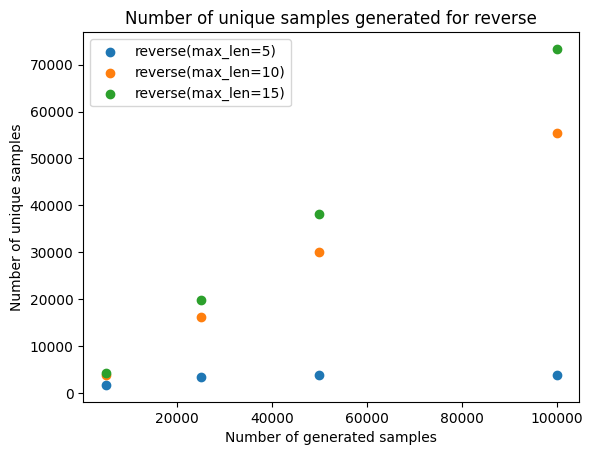

Generating for hist...


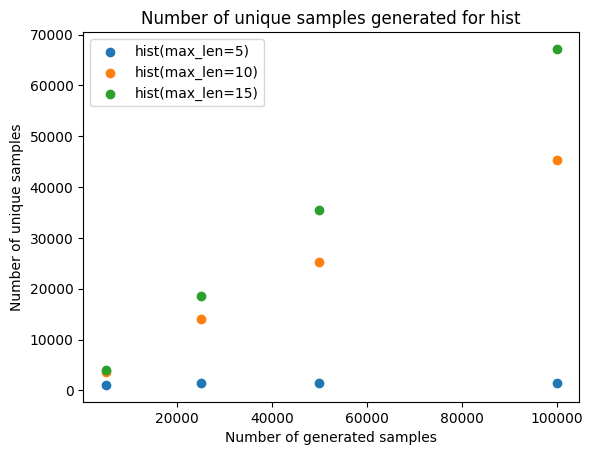

Generating for sort...


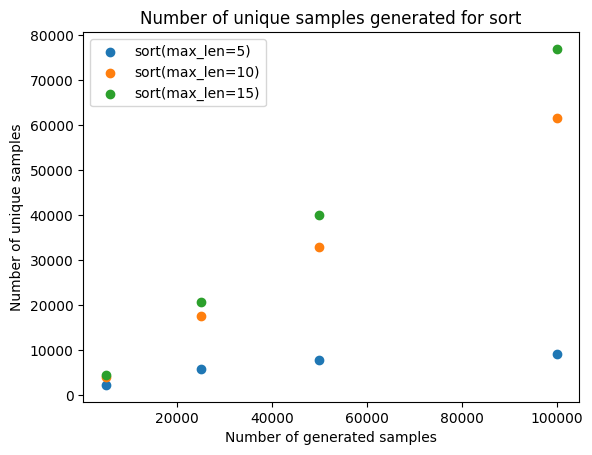

Generating for most-freq...


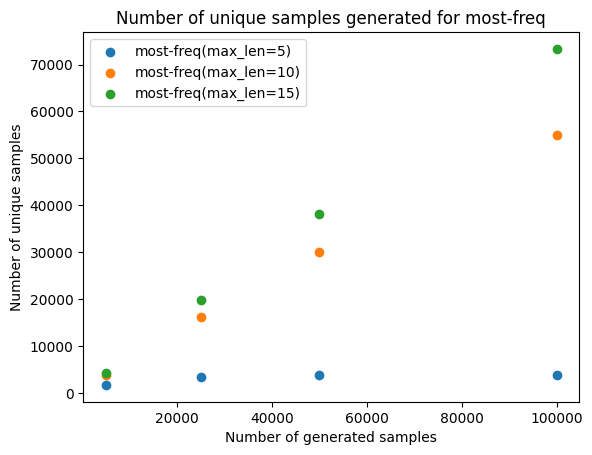

Generating for shuffle_dyck1...


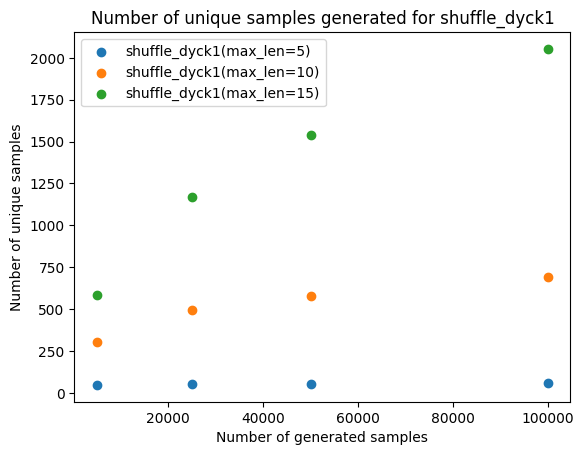

Generating for shuffle_dyck2...


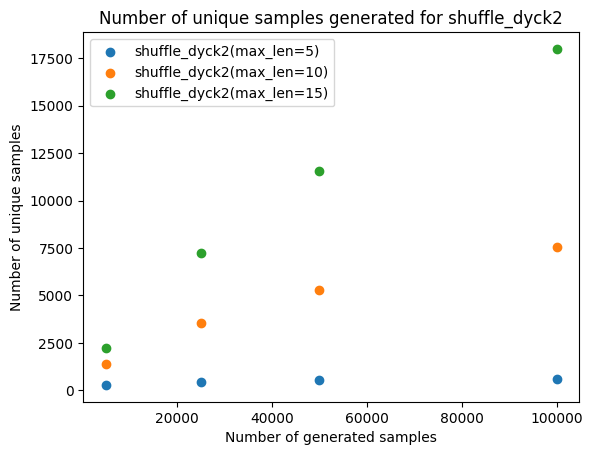

In [3]:
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

def generate_samples(model_name, n_samples, max_len):
    return n_samples, max_len, generate_dededup(model_name, n_samples, max_len)

for model_name in getAcceptedNamesAndInput().keys():
    print(f"Generating for {model_name}...")
    with ThreadPoolExecutor() as executor:
        futures = []
        for max_len in [5, 10, 15]:
            for n_samples in [5000, 25000, 50000, 100000]:
                futures.append(executor.submit(generate_samples, model_name, n_samples, max_len))

        X = {max_len: [] for max_len in [5, 10, 15]}
        Y = {max_len: [] for max_len in [5, 10, 15]}
        for future in as_completed(futures):
            n_samples, max_len, result = future.result()
            X[max_len].append(n_samples)
            Y[max_len].append(result)

        for max_len in [5, 10, 15]:
            plt.scatter(X[max_len], Y[max_len], label=f"{model_name}(max_len={max_len})")

    plt.xlabel("Number of generated samples")
    plt.ylabel("Number of unique samples")
    plt.title(f"Number of unique samples generated for {model_name}")
    plt.legend()
    plt.show()

In [ ]:
def test_n_samples_function(model_name: str, n_samples, max_len: int = 10, n_epochs: int = 50000, batch_size: int = 256, learning_rate: float = 1e-04, output_dir: str = None):
    model = generateModel(model_name, max_len)
    model.setRandomWeights()
    X, Y = generateAndEncodeData(model_name, max_len, n_samples, removeDuplicates=True)

    X_train = X[:int(0.85*len(X))]
    Y_train = Y[:int(0.85*len(Y))]
    X_val = X[int(0.85*len(X)):]
    Y_val = Y[int(0.85*len(Y)):]

    return model.train(X_train,Y_train, n_epochs, batch_size, learning_rate, False, X_val, Y_val, 0, 10, loss_fn=cross_entropy_loss, output_dir=output_dir)

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_test(model_name, n_samples):
    print(f"Testing {model_name} with {n_samples} samples...")
    metrics, validation = test_n_samples_function(model_name, n_samples, output_dir=f"saved_data/{model_name}/{n_samples}/")
    return model_name, n_samples, metrics, validation

max_workers = 5
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for model_name in getAcceptedNamesAndInput().keys():
        print(f"Testing {model_name}...")
        for n_samples in [5000, 10000, 25000, 50000, 100000]:
            future = executor.submit(run_test, model_name, n_samples)
            futures.append(future)

    for future in as_completed(futures):
        model_name, n_samples, metrics, validation = future.result()
        print(f"Completed {model_name} with {n_samples} samples")

Plotting results for reverse...


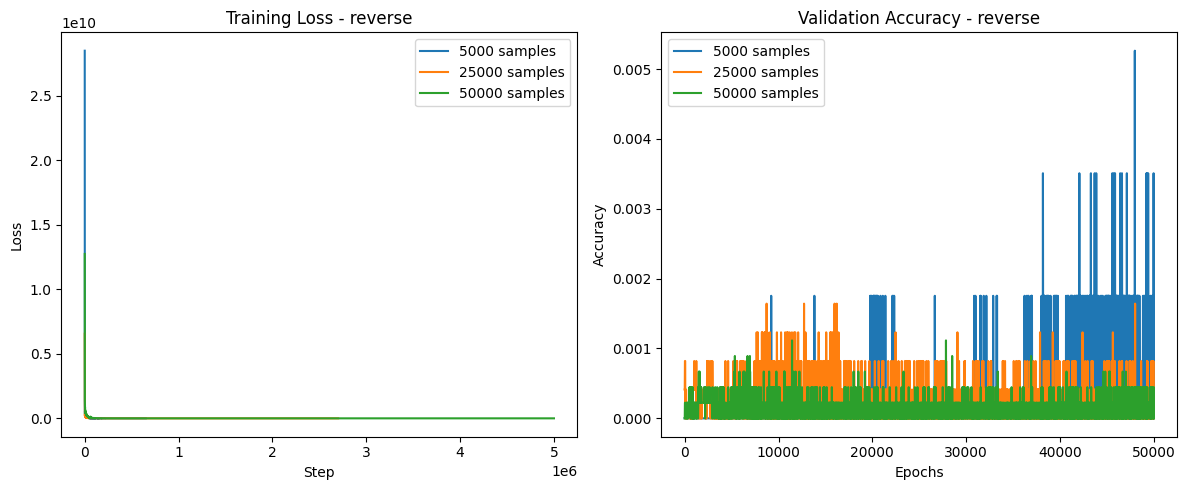

Plotting results for hist...


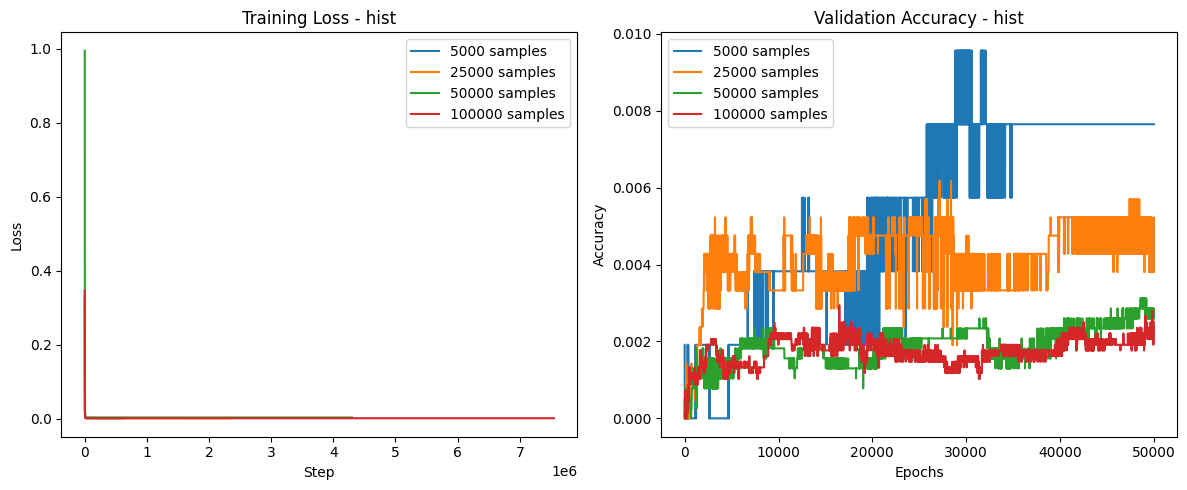

Plotting results for sort...


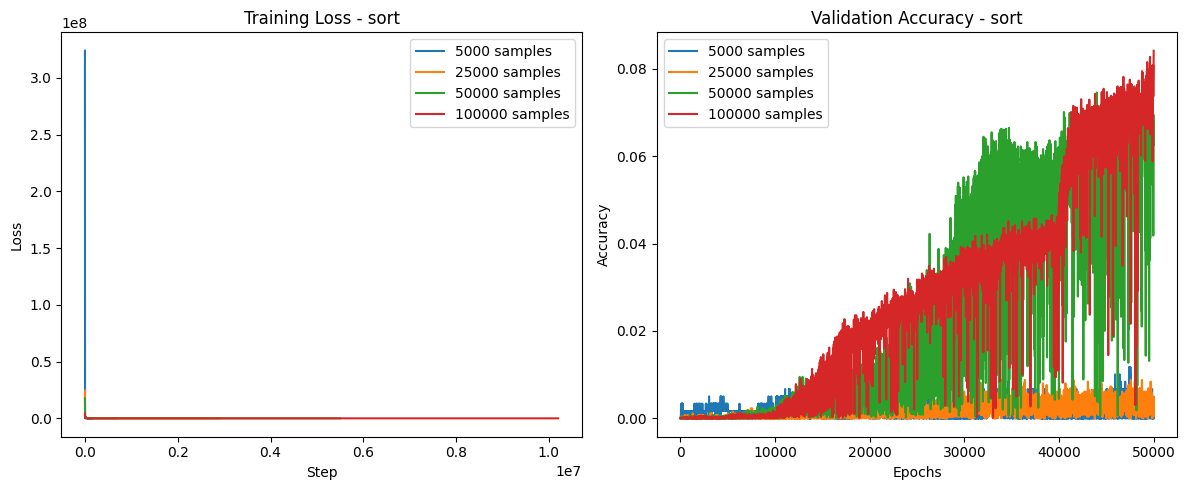

Plotting results for most-freq...


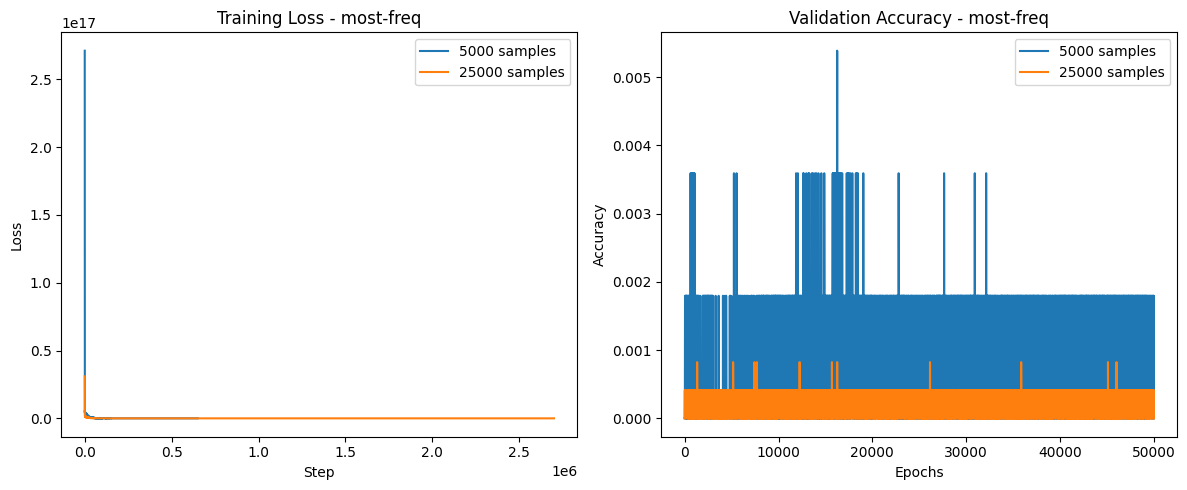

Plotting results for shuffle_dyck1...


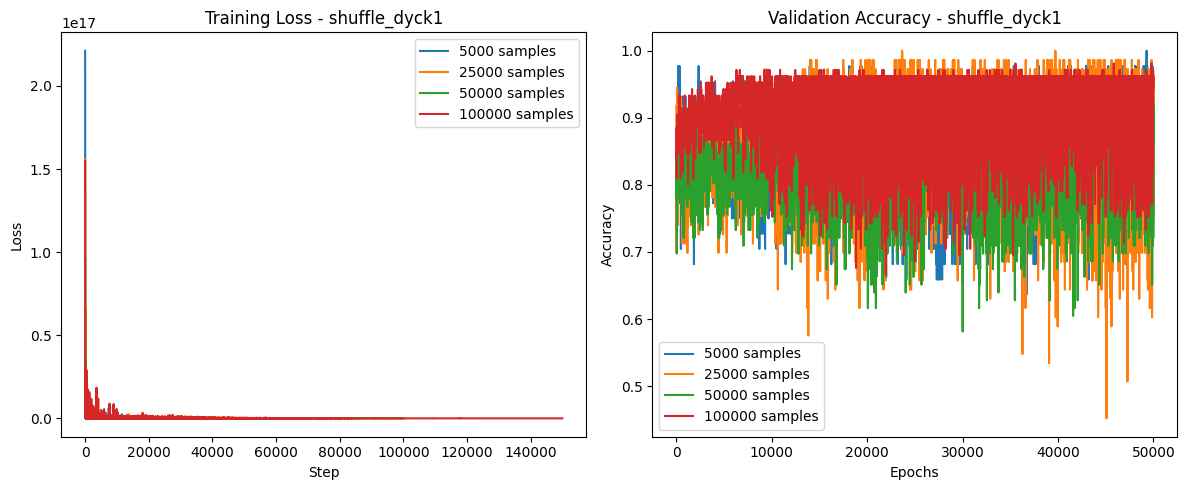

Plotting results for shuffle_dyck2...


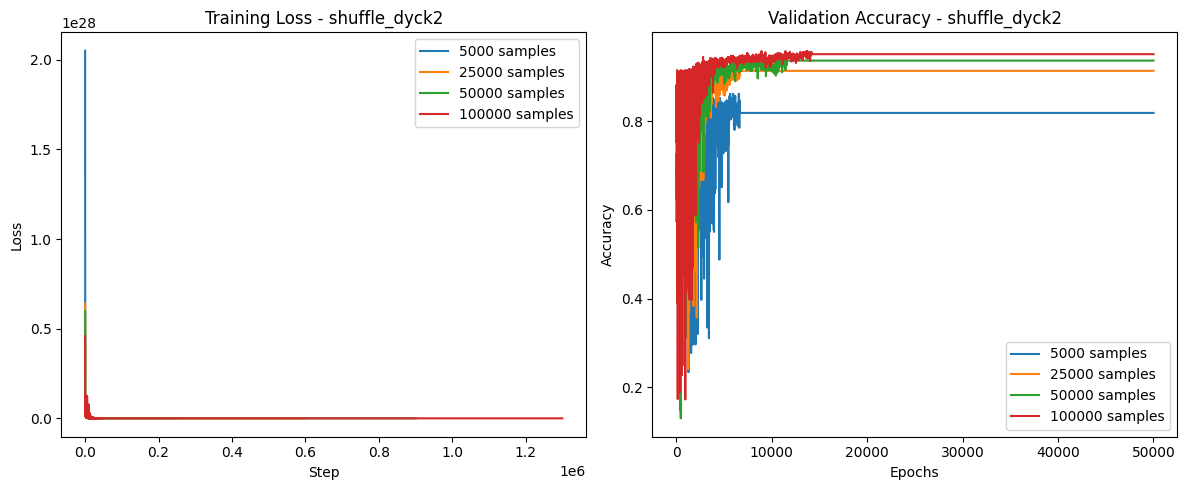

In [3]:
def load_results(model_name: str, n_samples: int):
    metrics = np.load(f"saved_data/{model_name}/{n_samples}/metrics.npy", allow_pickle=True)
    validation = np.load(f"saved_data/{model_name}/{n_samples}/validations.npy", allow_pickle=True)
    return metrics, validation

def plot_aggregated_results(model_name: str):
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    for n_samples in [5000, 25000, 50000, 100000]:
        try:
            metrics, _ = load_results(model_name, n_samples)
            plt.plot([m["step"] for m in metrics], 
                    [m["loss"] for m in metrics], 
                    label=f'{n_samples} samples')
        except:
            continue
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title(f"Training Loss - {model_name}")
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    for n_samples in [5000, 25000, 50000, 100000]:
        try:
            _, validation = load_results(model_name, n_samples)
            plt.plot(np.linspace(0, 50000, len(validation)), 
                    validation, 
                    label=f'{n_samples} samples')
        except:
            continue
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Validation Accuracy - {model_name}")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

for model_name in getAcceptedNamesAndInput().keys():
    print(f"Plotting results for {model_name}...")
    plot_aggregated_results(model_name)